In [40]:
# # # # !pip install torch
# # # !pip install keras
# # # !pip install numpy pandas
# # !pip install torch
# # !pip install scikit_learn
# !pip install matplotlib
# !pip install fasttext

In [1]:
# !pip install tensorflow
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-02-18 15:32:54.849475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 15:32:55.605057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/CUDA/11.7.0/nvvm/lib64:/opt/apps/software/CUDA/11.7.0/extras/CUPTI/lib64:/opt/apps/software/CUDA/11.7.0/lib:/opt/apps/software/Python/3.7.13-GCCcore-11.2.0/lib:/opt/apps/software/OpenSSL/1.1/lib:/opt/apps/software/libffi/3.4.2-GCCcore-11.2.0/lib64:/opt/apps/software/GMP/6.2.1-GCCcore-11.2.0/lib:/opt/apps/software/XZ/5.2.5-GCCcore-11.2.0/lib:/opt/apps/software/SQLite/3.36-GCCcore-

In [26]:
# Specify GPU
device = torch.device("cuda")

In [112]:
# Load dataset
df = pd.read_csv('preprocessed.csv')
df.head()

,text,class,char_length,token_length
0,sex wife threatening suicide recently left wif...,1,364,54
1,weird affected compliment coming know girl fee...,0,76,11
2,finally thousand hear thousand bad year swear ...,0,66,10
3,need help help hard,1,33,6
4,ism lost hello adam sixteen 've struggling yea...,1,1376,193


# Do Splitting and get vocab first

In [127]:
# Split dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['class'],
                                                                    random_state=0,
                                                                    test_size=0.2,
                                                                    stratify=df['class'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=0,
                                                                test_size=0.125,
                                                                stratify=temp_labels)

In [128]:
max_length = max([len(s.split()) for s in train_text])
max_length

5850

In [129]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
vocab_size = len(tokenizer.word_index) + 1

In [134]:
# Tokenize and encode sequences in all datasets
tokens_train = tokenize_and_encode(train_text)
tokens_val = tokenize_and_encode(val_text)
tokens_test = tokenize_and_encode(test_text)

In [136]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(tokens_train), torch.from_numpy(train_labels.to_numpy()))
val_data = TensorDataset(torch.from_numpy(tokens_val), torch.from_numpy(val_labels.to_numpy()))

# Sampler for sampling the data
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# DataLoader
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

LSTM Architecture

In [194]:
class LSTM(nn.Module):


    def __init__(self, vocab_size, output_size, 
                 embedding_dim, hidden_dim, n_layers, 
                 dropout_rate, pre_trained=False, embedding_vectors=None):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        if pre_trained:
            self.embedding, num_embeddings, embedding_dim = create_emb_layer(embedding_vectors, True)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_rate, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3) # dropout_rate
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        
        return hidden
        

In [138]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Model Settings, eg: hyperparams, loss functions, etc

Note: We are still using FastText here

In [198]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
SEED = 0

In [199]:
# Instantiate the model w/ hyperparams
embedding_dim = 300
hidden_dim = 128
output_size = 1
n_layers = 2
dropout = 0.5

In [379]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# push to GPU
criterion = criterion.to(device)

In [147]:
# # !pip install fasttext
import fasttext
embedding = fasttext.load_model('cc.es.300.bin')

In [201]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab, embedding_dim):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = np.zeros((vocab_size, embedding_dim))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		weight_matrix[i] = embedding.get_sentence_vector(word)

	return weight_matrix

In [202]:
# get vectors in the right order
embedding_vectors_fast = get_weight_matrix(embedding, tokenizer.word_index, 300)
embedding_vectors_fast = np.float32(embedding_vectors_fast)

In [203]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    # emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [205]:
model = LSTM(vocab_size, output_size, 300, hidden_dim, n_layers, dropout, 
                       pre_trained=True, embedding_vectors=embedding_vectors_glove)
model.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_glove))

print("FastText pre trained embedding")
print(model)

print(f'Model has {count_parameters(model):,} trainable parameters')

With gloVe pre trained embedding weights
LSTM(
  (embedding): Embedding(75967, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model has 352,385 trainable parameters


# Model evaluation functions for reusability

In [206]:
def binary_accuracy(preds, labels):
    # convert output probabilities to predicted class (0 or 1)
    preds = torch.round(preds.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct = np.sum(correct)

    acc = num_correct/len(correct)

    return acc

In [184]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches of train data
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
#         if step % 50 == 0 and not step == 0:
#             print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        # batch = [r.to(device) for r in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        # initialize hidden state
        h = model.init_hidden(len(inputs))

        # move to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # Create new variables for the hidden state
        h = tuple([each.data for each in h])

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for current batch
        preds, h = model(inputs, h)
        
        # compute the loss between actual and predicted values
        loss = criterion(preds.squeeze(), labels.float())

        # add on to the total loss
        total_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()

        # clip the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)

        # compute accuracy
        acc = binary_accuracy(preds, labels)

        # add on to the total accuracy
        total_accuracy += acc.item()

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # compute the training acc of the epoch
    avg_acc = total_accuracy / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss, accuracy and predictions
    return avg_loss, avg_acc, total_preds

In [207]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers

    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
#         if step % 100 == 0 and not step == 0:
#             print('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        # batch = [t.to(device) for t in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        # initialize hidden state
        val_h = model.init_hidden(len(inputs))

        # move to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # Create new variables for the hidden state
        val_h = tuple([each.data for each in val_h])

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds, val_h = model(inputs, val_h)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds.squeeze(), labels.float())

            total_loss += loss.item()

            acc = binary_accuracy(preds, labels)

            total_accuracy += acc.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # compute the validation acc of the epoch
    avg_acc = total_accuracy / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, total_preds

# Model preparation, training, evaluation (1)

In [380]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
SEED = 0
import random
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set random seed for GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    
# Enable deterministic behavior for CUDA operations, if applicable
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [381]:
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys.pt'

In [382]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change+1,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10: #terminate after >10
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.540
Validation Loss: 0.540

Training Accuracy: 0.924
Validation Accuracy: 0.923

 Epoch 2 / 30

Evaluating...
Improved

Training Loss: 0.538
Validation Loss: 0.540

Training Accuracy: 0.925
Validation Accuracy: 0.923

 Epoch 3 / 30

Evaluating...
Improved

Training Loss: 0.538
Validation Loss: 0.539

Training Accuracy: 0.926
Validation Accuracy: 0.922

 Epoch 4 / 30

Evaluating...
Improved

Training Loss: 0.538
Validation Loss: 0.539

Training Accuracy: 0.926
Validation Accuracy: 0.922

 Epoch 5 / 30

Evaluating...
Improved

Training Loss: 0.538
Validation Loss: 0.539

Training Accuracy: 0.926
Validation Accuracy: 0.924

 Epoch 6 / 30

Evaluating...
Improved

Training Loss: 0.538
Validation Loss: 0.539

Training Accuracy: 0.927
Validation Accuracy: 0.923

 Epoch 7 / 30

Evaluating...
No improvement

 Epoch 8 / 30

Evaluating...
Improved

Training Loss: 0.537
Validation Loss: 0.539

Training Accuracy: 0.927
Validation Accuracy: 0.

In [390]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (1)

In [391]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [392]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [393]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9154    0.9331    0.9242      2899
           1     0.9318    0.9138    0.9227      2901

    accuracy                         0.9234      5800
   macro avg     0.9236    0.9235    0.9234      5800
weighted avg     0.9236    0.9234    0.9234      5800



In [394]:
model_1_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_1_test_precision_score = precision_score(test_labels, total_preds)
model_1_test_recall_score = recall_score(test_labels, total_preds)
model_1_test_f1_score = f1_score(test_labels, total_preds)

In [395]:
print(model_1_test_accuracy_score)
print(model_1_test_precision_score)
print(model_1_test_recall_score)
print(model_1_test_f1_score)

0.923448275862069
0.9318101933216169
0.9138228197173388
0.9227288548555517


In [396]:
model1_train_accuracies = model_train_accuracies
model1_valid_accuracies = model_valid_accuracies

# Model preparation, training, evaluation (2)

In [399]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
SEED = 0
import random
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set random seed for GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    
# Enable deterministic behavior for CUDA operations, if applicable
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [400]:
# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys_2.pt'

In [401]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change+1,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10:
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.537
Validation Loss: 0.539

Training Accuracy: 0.929
Validation Accuracy: 0.924

 Epoch 2 / 30

Evaluating...
No improvement

 Epoch 3 / 30

Evaluating...
No improvement

 Epoch 4 / 30

Evaluating...
No improvement

 Epoch 5 / 30

Evaluating...
No improvement

 Epoch 6 / 30

Evaluating...
No improvement

Evaluating...
No improvement after 6 times

Evaluating...
No improvement after 7 times

Evaluating...
No improvement after 8 times

Evaluating...
No improvement after 9 times

Evaluating...
No improvement after 10 times

Evaluating...
No improvement after 11 times
Early Termination


In [402]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (2)

In [403]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [404]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [409]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9148    0.9331    0.9238      2899
           1     0.9318    0.9131    0.9224      2901

    accuracy                         0.9231      5800
   macro avg     0.9233    0.9231    0.9231      5800
weighted avg     0.9233    0.9231    0.9231      5800



In [410]:
model_2_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_2_test_precision_score = precision_score(test_labels, total_preds)
model_2_test_recall_score = recall_score(test_labels, total_preds)
model_2_test_f1_score = f1_score(test_labels, total_preds)

In [411]:
print(model_2_test_accuracy_score)
print(model_2_test_precision_score)
print(model_2_test_recall_score)
print(model_2_test_f1_score)

0.9231034482758621
0.9317622230038691
0.9131334022750776
0.9223537604456824


In [412]:
model2_train_accuracies = model_train_accuracies
model2_valid_accuracies = model_valid_accuracies

# Model preparation, training, evaluation (3)

In [327]:
# Define the loss function
criterion = nn.BCELoss()
# push to GPU
criterion = criterion.to(device)

In [328]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
SEED = 0
import random
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set random seed for GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    
# Enable deterministic behavior for CUDA operations, if applicable
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [329]:
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys_3.pt'

In [330]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10:
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.707
Validation Loss: 0.431

Training Accuracy: 0.917
Validation Accuracy: 0.920

 Epoch 2 / 30

Evaluating...
Improved

Training Loss: 0.304
Validation Loss: 0.241

Training Accuracy: 0.916
Validation Accuracy: 0.919

 Epoch 3 / 30

Evaluating...
Improved

Training Loss: 0.244
Validation Loss: 0.225

Training Accuracy: 0.919
Validation Accuracy: 0.919

 Epoch 4 / 30

Evaluating...
Improved

Training Loss: 0.234
Validation Loss: 0.221

Training Accuracy: 0.920
Validation Accuracy: 0.920

 Epoch 5 / 30

Evaluating...
Improved

Training Loss: 0.230
Validation Loss: 0.218

Training Accuracy: 0.921
Validation Accuracy: 0.920

 Epoch 6 / 30

Evaluating...
Improved

Training Loss: 0.226
Validation Loss: 0.216

Training Accuracy: 0.921
Validation Accuracy: 0.921

 Epoch 7 / 30

Evaluating...
Improved

Training Loss: 0.223
Validation Loss: 0.214

Training Accuracy: 0.922
Validation Accuracy: 0.920

 Epoch 8 / 30

Evaluating...
Improved

T

In [331]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (3)

In [332]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [333]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [334]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9235    0.9203    0.9219      2899
           1     0.9206    0.9238    0.9222      2901

    accuracy                         0.9221      5800
   macro avg     0.9221    0.9221    0.9221      5800
weighted avg     0.9221    0.9221    0.9221      5800



In [335]:
model_3_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_3_test_precision_score = precision_score(test_labels, total_preds)
model_3_test_recall_score = recall_score(test_labels, total_preds)
model_3_test_f1_score = f1_score(test_labels, total_preds)

In [336]:
print(model_3_test_accuracy_score)
print(model_3_test_precision_score)
print(model_3_test_recall_score)
print(model_3_test_f1_score)

0.9220689655172414
0.9206458261765716
0.9238193726301276
0.9222298692360634


In [337]:
model3_train_accuracies = model_train_accuracies
model3_valid_accuracies = model_valid_accuracies

# Model preparation, training, evaluation (4)

In [338]:
# Define constants
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
SEED = 0
import random
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set random seed for GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    
# Enable deterministic behavior for CUDA operations, if applicable
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [339]:
# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
# push to GPU
model = model.to(device)
MODEL_WEIGHTS_PATH = 'lstm_ys_4.pt'

In [340]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model_train_losses = []
model_valid_losses = []

# empty lists to store training and validation acc of each epoch
model_train_accuracies = []
model_valid_accuracies = []

no_change = 0 #track how many times there is no improvements

# for each epoch
for epoch in range(EPOCHS):
    if no_change<5: #once 5 times, we can change the weights, settings, etc  
        print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement")
            no_change+=1         
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

    else:
        # train model
        train_loss, train_acc, _ = train()

        # evaluate model
        valid_loss, valid_acc, _ = evaluate()

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
            no_change=0 #there is improvement, reset to 0
            print("Improved")
            # append training and validation loss
            model_train_losses.append(train_loss)
            model_valid_losses.append(valid_loss)

            # append training and validation acc
            model_train_accuracies.append(train_acc)
            model_valid_accuracies.append(valid_acc)

            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')

            print(f'\nTraining Accuracy: {train_acc:.3f}')
            print(f'Validation Accuracy: {valid_acc:.3f}')
            
        else:
            print("No improvement after", no_change,"times")
            LEARNING_RATE=1e-4 # modify learning rate, see if it helps
            no_change+=1
            if no_change>6:  #after 6 times no change, modify learning rate somemore
                LEARNING_RATE=1e-3 # modify learning rate, see if it helps
                if no_change>10:
                    print("Early Termination")
                    break           


 Epoch 1 / 30

Evaluating...
Improved

Training Loss: 0.203
Validation Loss: 0.203

Training Accuracy: 0.926
Validation Accuracy: 0.925

 Epoch 2 / 30

Evaluating...
Improved

Training Loss: 0.203
Validation Loss: 0.203

Training Accuracy: 0.926
Validation Accuracy: 0.925

 Epoch 3 / 30

Evaluating...
Improved

Training Loss: 0.203
Validation Loss: 0.203

Training Accuracy: 0.927
Validation Accuracy: 0.925

 Epoch 4 / 30

Evaluating...
Improved

Training Loss: 0.203
Validation Loss: 0.203

Training Accuracy: 0.926
Validation Accuracy: 0.925

 Epoch 5 / 30

Evaluating...
Improved

Training Loss: 0.203
Validation Loss: 0.203

Training Accuracy: 0.926
Validation Accuracy: 0.925

 Epoch 6 / 30

Evaluating...
Improved

Training Loss: 0.203
Validation Loss: 0.203

Training Accuracy: 0.926
Validation Accuracy: 0.925

 Epoch 7 / 30

Evaluating...
Improved

Training Loss: 0.203
Validation Loss: 0.203

Training Accuracy: 0.926
Validation Accuracy: 0.925

 Epoch 8 / 30

Evaluating...
Improved

T

In [341]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

# Test (4)

In [342]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [343]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):


    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

In [344]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9238    0.9203    0.9221      2899
           1     0.9207    0.9242    0.9224      2901

    accuracy                         0.9222      5800
   macro avg     0.9222    0.9222    0.9222      5800
weighted avg     0.9222    0.9222    0.9222      5800



In [345]:
model_4_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_4_test_precision_score = precision_score(test_labels, total_preds)
model_4_test_recall_score = recall_score(test_labels, total_preds)
model_4_test_f1_score = f1_score(test_labels, total_preds)

In [348]:
print(model_4_test_accuracy_score)
print(model_4_test_precision_score)
print(model_4_test_recall_score)
print(model_4_test_f1_score)

0.9222413793103448
0.9206730769230769
0.9241640813512582
0.9224152761052812


In [349]:
model4_train_accuracies = model_train_accuracies
model4_valid_accuracies = model_valid_accuracies

# Comparison

In [353]:
# !pip install prettytable

In [354]:
from prettytable import PrettyTable

In [414]:
table = PrettyTable()
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

table.add_row(['Adam Optimizer with BCEWithLogitsLoss', 
               format(model_1_test_accuracy_score, '.4f'), 
               format(model_1_test_precision_score, '.4f'), 
               format(model_1_test_recall_score, '.4f'), 
               format(model_1_test_f1_score, '.4f')])

table.add_row(['SGD Optimizer with BCEWithLogitsLoss', 
               format(model_2_test_accuracy_score, '.4f'), 
               format(model_2_test_precision_score, '.4f'), 
               format(model_2_test_recall_score, '.4f'), 
               format(model_2_test_f1_score, '.4f')])

table.add_row(['Adam Optimizer with BCELoss', 
               format(model_3_test_accuracy_score, '.4f'), 
               format(model_3_test_precision_score, '.4f'), 
               format(model_3_test_recall_score, '.4f'), 
               format(model_3_test_f1_score, '.4f')])

table.add_row(['SGD Optimizer with BCELoss', 
               format(model_4_test_accuracy_score, '.4f'), 
               format(model_4_test_precision_score, '.4f'), 
               format(model_4_test_recall_score, '.4f'), 
               format(model_4_test_f1_score, '.4f')])

print(table)

+---------------------------------------+----------+-----------+--------+----------+
|                 Model                 | Accuracy | Precision | Recall | F1 Score |
+---------------------------------------+----------+-----------+--------+----------+
| Adam Optimizer with BCEWithLogitsLoss |  0.9234  |   0.9318  | 0.9138 |  0.9227  |
|  SGD Optimizer with BCEWithLogitsLoss |  0.9231  |   0.9318  | 0.9131 |  0.9224  |
|      Adam Optimizer with BCELoss      |  0.9221  |   0.9206  | 0.9238 |  0.9222  |
|       SGD Optimizer with BCELoss      |  0.9222  |   0.9207  | 0.9242 |  0.9224  |
+---------------------------------------+----------+-----------+--------+----------+


Since we are interested in Recall and F1: <Br> <b>
SGD Optimizer with BCELoss is the best for recall at 0.9242 and Adam Optimizer with BCEWithLogitsLoss is best for F1 at 0.9227 <br>
If we sacrifice 0.0003 F1 score for 0.0104, it is not that bad of a trade. Hence, I conclude that the last model might be the best across this 4 LSTM models

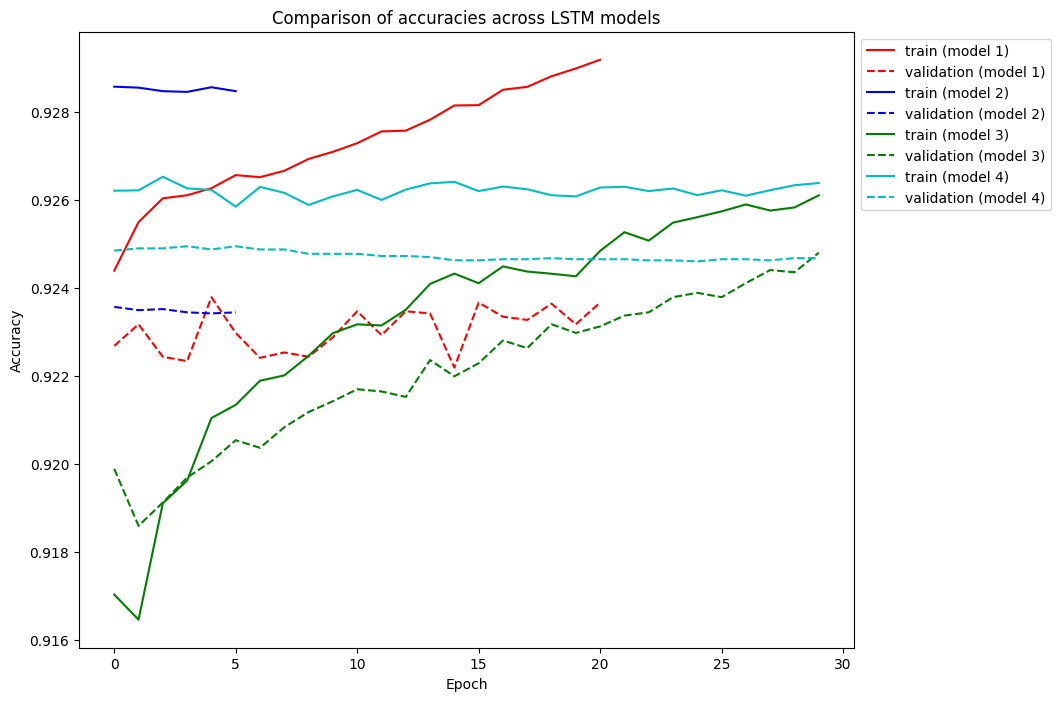

In [413]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(model1_train_accuracies, "r-")
plt.plot(model1_valid_accuracies, "r--")
plt.plot(model2_train_accuracies, "b-")
plt.plot(model2_valid_accuracies, "b--")
plt.plot(model3_train_accuracies, "g-")
plt.plot(model3_valid_accuracies, "g--")
plt.plot(model4_train_accuracies, "c-")
plt.plot(model4_valid_accuracies, "c--")
plt.title('Comparison of accuracies across LSTM models')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train (model 1)', 'validation (model 1)', 'train (model 2)', 'validation (model 2)', 'train (model 3)', 'validation (model 3)', 'train (model 4)', 'validation (model 4)'], 
           bbox_to_anchor=(1, 1))
           #loc='upper left')
plt.show()